# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages, which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission if necessary. 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

In addition to implementing code, there is a writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) that can be used to guide the writing process. Completing the code template and writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/481/view) for this project.

The [rubric](https://review.udacity.com/#!/rubrics/481/view) contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this Ipython notebook and also discuss the results in the writeup file.


>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle

# TODO: Fill this in based on where you saved the training and testing data

training_file = 'train.p'
validation_file= 'valid.p'
testing_file = 'test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [2]:
### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results

# TODO: Number of training examples
n_train = len(X_train)

# TODO: Number of validation examples
n_validation = len(X_valid)

# TODO: Number of testing examples.
n_test = len(X_test)

# TODO: What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# TODO: How many unique classes/labels there are in the dataset.
n_classes = len(set(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc. 

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections. It can be interesting to look at the distribution of classes in the training, validation and test set. Is the distribution the same? Are there more examples of some classes than others?

In [3]:
import csv

with open('signnames.csv', mode='rt') as file:
    file.readline()   # discard header
    sign_names = { int(r[0]) : r[1] for r in csv.reader(file) }

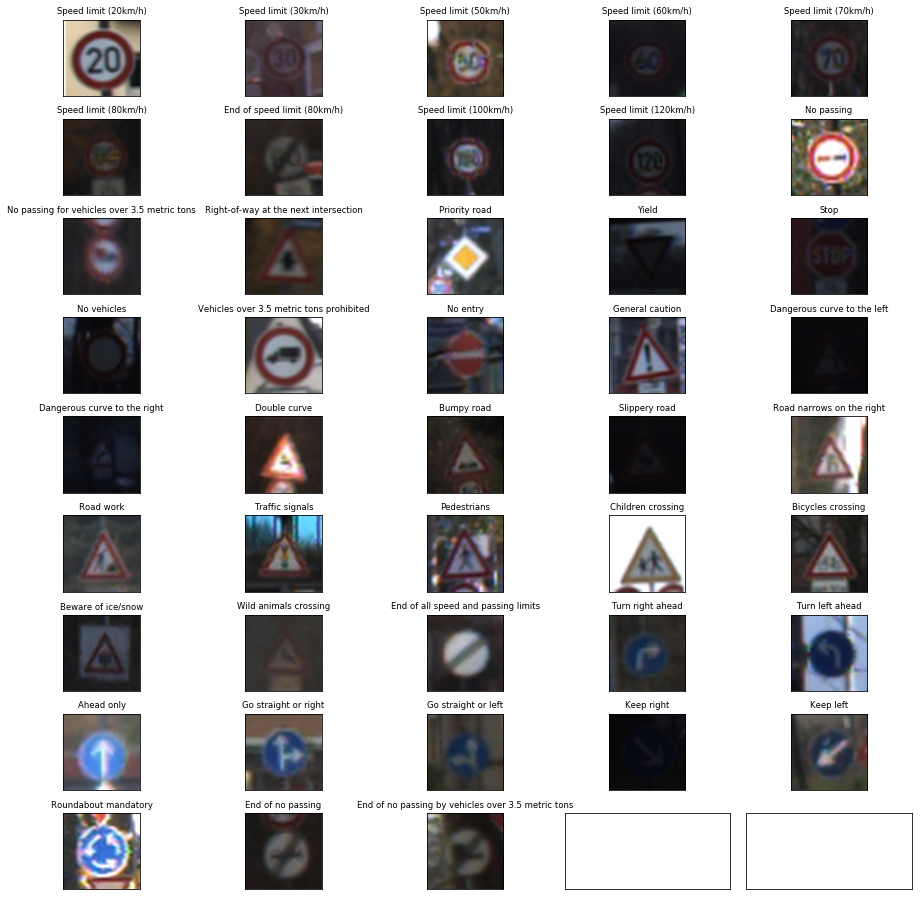

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import math
%matplotlib inline 

classes, indices = np.unique(y_train, return_index=True)   

columns = 5
rows = math.ceil(n_classes/columns)
figsize=(16, 16)
fontsize=8.5

fig, axes = plt.subplots(rows, columns, figsize=figsize,
                         subplot_kw={'xticks': [], 'yticks': []})

fig.subplots_adjust(hspace=0.3, wspace=0.10)

for ax, i in zip(axes.flat, indices):
    ax.imshow(X_train[i], interpolation='lanczos', cmap='viridis')
    ax.set_title(sign_names[y_train[i]], fontsize=fontsize)
    
plt.show()

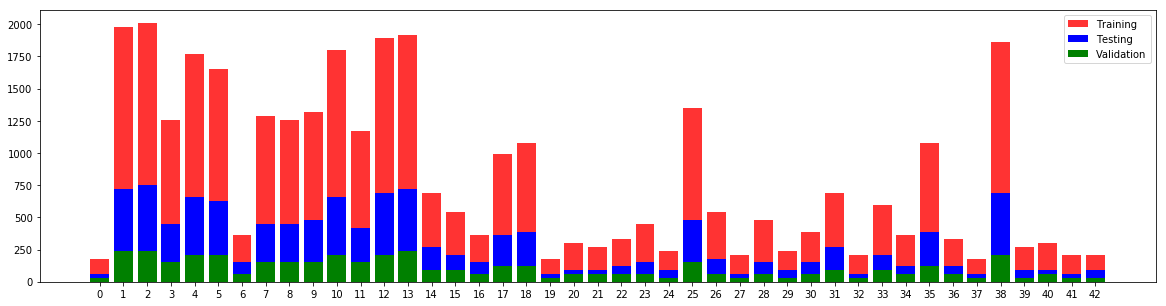

In [5]:
from collections import Counter

fig, ax = plt.subplots(figsize=(20,5))

D = Counter(y_train)
plt.xticks(range(len(D)), D.keys())
plt.bar(range(len(D)), D.values(), color="red", alpha=0.8, label='Training')

D = Counter(y_test)
plt.xticks(range(len(D)), D.keys())
plt.bar(range(len(D)), D.values(), color="blue",label='Testing')

D = Counter(y_valid)
plt.xticks(range(len(D)), D.keys())
plt.bar(range(len(D)), D.values(), color="green",label='Validation')

legend = ax.legend()

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play! 

With the LeNet-5 solution from the lecture, you should expect a validation set accuracy of about 0.89. To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Pre-process the Data Set 

Minimally, the image data should be normalized so that the data has mean zero and equal variance. For image data, `(pixel - 128)/ 128` is a quick way to approximately normalize the data and can be used in this project. 

Other pre-processing steps are optional. You can try different techniques to see if it improves performance. 

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

In [6]:
%%time
from sklearn.utils import shuffle
import tensorflow as tf

def preprocess(x_in):

    x_out = []
#    x_in_t = tf.image.rgb_to_hsv(x_in)
    x_in_t = tf.map_fn(lambda img: tf.image.per_image_standardization(img), x_in, dtype=tf.float32)
    
    with tf.Session() as sess:
        x_out = x_in_t.eval()
    return x_out

X_train = preprocess(X_train)
X_valid = preprocess(X_valid)
X_test = preprocess(X_test)

CPU times: user 21.8 s, sys: 3.3 s, total: 25.1 s
Wall time: 12 s


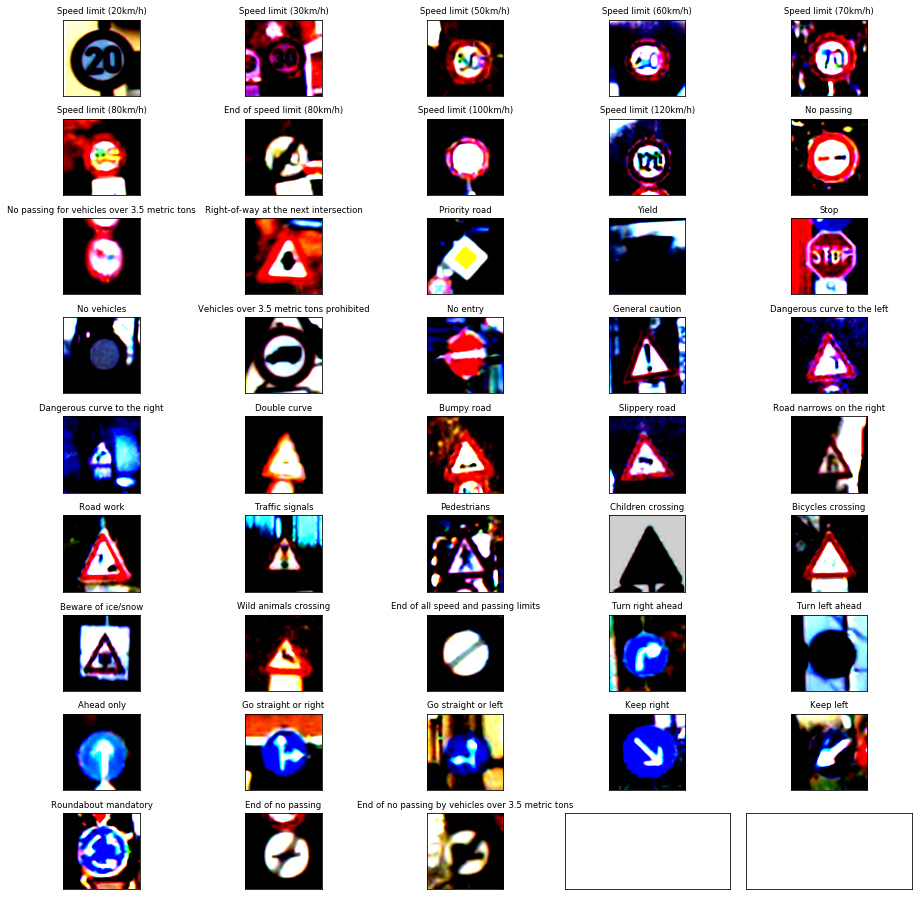

In [7]:
fig, axes = plt.subplots(rows, columns, figsize=figsize,
                         subplot_kw={'xticks': [], 'yticks': []})

fig.subplots_adjust(hspace=0.3, wspace=0.10)

for ax, i in zip(axes.flat, indices):
    ax.imshow(X_train[i], interpolation='lanczos', cmap='viridis')
    ax.set_title(sign_names[y_train[i]], fontsize=fontsize)
    
plt.show()

In [8]:
import math

def distort_input(x_in):
    x_t = tf.convert_to_tensor(x_in)
    
    x_t = tf.map_fn(lambda img: tf.random_crop(img, [32, 32, 3]), x_t, dtype=tf.float32)
    # tf.contrib.image.rotate is experimental and not avaialble on all Tensorflow installations
    x_t = tf.contrib.image.rotate(x_in, tf.random_uniform([len(x_in)], maxval=math.pi/8))
    x_t = tf.map_fn(lambda img: tf.image.random_brightness(img, max_delta=63./255.), x_t, dtype=tf.float32)
#    x_t = tf.map_fn(lambda img: tf.image.random_saturation(img, lower=0.5, upper=1.5), x_t, dtype=tf.float32)
#    x_t = tf.map_fn(lambda img: tf.image.random_hue(img, max_delta=0.2), x_t, dtype=tf.float32)
    x_t = tf.map_fn(lambda img: tf.image.random_contrast(img, lower=0.2, upper=1.8), x_t, dtype=tf.float32)
    x_t = tf.map_fn(lambda img: tf.image.per_image_standardization(img), x_t, dtype=tf.float32)

    with tf.Session() as sess:
        x_out = x_t.eval()
    return x_out

In [9]:
def augment_input(x_in, y_in):
    # Double the data size of clasess whose count is less than half of max count of any class.
    D = Counter(y_in)
    augument_threshold = max(D.values())/2
    print(augument_threshold)

    x_augment = []
    y_augment = []
    for num, value in enumerate(D.values()):
        if value < augument_threshold:
            selected_class = np.where(y_in == num)
            for i in selected_class[0]:
                x_augment.append(x_in[i])
                y_augment.append(num)
                
    return x_augment, y_augment         

In [10]:
def augment_class(x_in, y_in, classid, target):
    # Double the data size of clasess whose count is less than half of max count of any class.

    x_augment = []
    y_augment = []
    running_total = 0

    selected_class = np.where(y_in == classid)
    
    while running_total < target:

        for i in selected_class[0]:
            x_augment.append(x_in[i])
            y_augment.append(classid)
            running_total += 1
                
    print (running_total)
    return x_augment, y_augment  

In [11]:
%%time
x_augment, y_augment = augment_input(X_train, y_train)

1005.0
CPU times: user 8 ms, sys: 0 ns, total: 8 ms
Wall time: 8.55 ms


In [12]:
%%time
distorted_x = distort_input(np.array(x_augment))

CPU times: user 10.6 s, sys: 1.12 s, total: 11.7 s
Wall time: 11.5 s


In [13]:
print (len(X_train))
print (len(y_train))

print (len(x_augment))
print (len(y_augment))

print ("orginal", (X_train.shape))
print ("Distorted", (distorted_x.shape))
print (len(x_augment))
X_train2 = np.append(X_train, distorted_x, axis=0)
y_train2 = np.append(y_train, np.array(y_augment), axis=0)

print (len(X_train2))
print (len(y_train2))

X_train = X_train2
y_train = y_train2

print (len(X_train))
print (len(y_train))

34799
34799
10109
10109
orginal (34799, 32, 32, 3)
Distorted (10109, 32, 32, 3)
10109
44908
44908
44908
44908


In [14]:
%%time
problamtic_classes = [0,1,2,3,4,5,6,7,8,24,27]
for classid in problamtic_classes:
    x_augment, y_augment = augment_class(X_train, y_train, classid, 500)
    distorted_x = distort_input(np.array(x_augment))
    X_train2 = np.append(X_train, distorted_x, axis=0)
    y_train2 = np.append(y_train, np.array(y_augment), axis=0)

    X_train = X_train2
    y_train = y_train2

print (len(X_train))
print (len(y_train))


720
1980
2010
1260
1770
1650
720
1290
1260
960
840
59368
59368
CPU times: user 14.3 s, sys: 3.36 s, total: 17.7 s
Wall time: 14.3 s


In [15]:
X_train, y_train = shuffle(X_train, y_train)

##### New Training Data Summary after Augmentation

In [16]:
n_train = len(X_train)
image_shape = X_train[0].shape
n_classes = len(set(y_train))

print("Number of training examples =", n_train)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 59368
Image data shape = (32, 32, 3)
Number of classes = 43


<Container object of 43 artists>

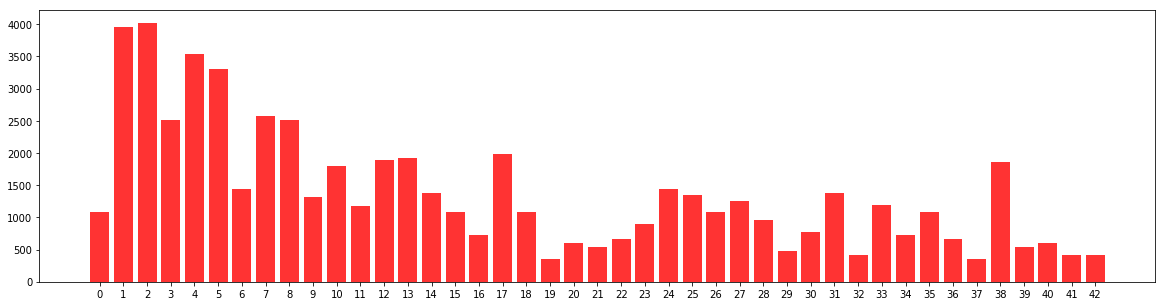

In [17]:
fig, ax = plt.subplots(figsize=(20,5))

D = Counter(y_train)
plt.xticks(range(len(D)), D.keys())
plt.bar(range(len(D)), D.values(), color="red", alpha=0.8, label='Training')

### Dealing with Imbalanced Data

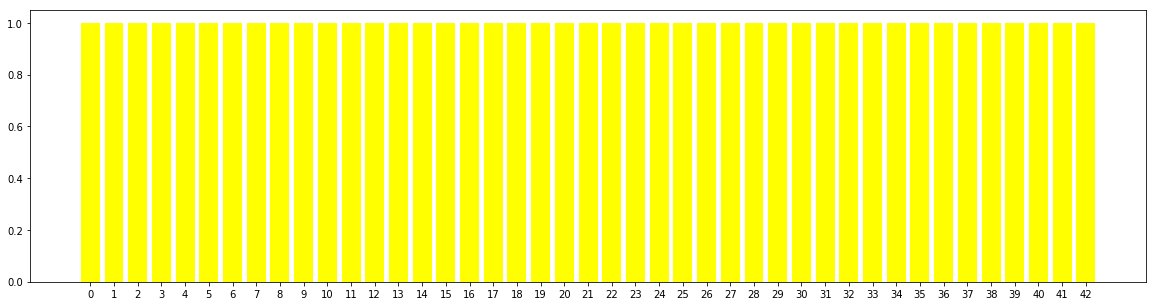

In [18]:
D = Counter(y_train)
maximum = max(D.values())
weights = np.array(list(D.values()))
weights = weights/maximum
#weights = 0.0232/weights
#weights = 1/weights
weights.fill(1)

fig, ax = plt.subplots(figsize=(20,5))
plt.xticks(range(len(D)), D.keys())
plot = plt.bar(range(len(D)), weights, color="yellow",label='Weights')

In [19]:
import tensorflow as tf

EPOCHS = 20
BATCH_SIZE = 256

### Model Architecture

In [20]:
from tensorflow.contrib.layers import flatten

def LeNet_Fast(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # SOLUTION: Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 3, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # SOLUTION: Activation.
    conv1 = tf.nn.relu(conv1)

    # SOLUTION: Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID', name='conv1')

    # SOLUTION: Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # SOLUTION: Activation.
    conv2 = tf.nn.relu(conv2)

    # SOLUTION: Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID', name='conv2')

    # SOLUTION: Flatten. Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2)
    
    # SOLUTION: Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # SOLUTION: Activation.
    fc1    = tf.nn.relu(fc1)

    # SOLUTION: Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # SOLUTION: Activation.
    fc2    = tf.nn.relu(fc2)
    
    fc2_drop = tf.nn.dropout(fc2, keep_prob)
    
    # SOLUTION: Layer 5: Fully Connected. Input = 84. Output = 10.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2_drop, fc3_W) + fc3_b
    
    return logits


In [21]:
def LeNet_Deep(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # SOLUTION: Layer 1: Convolutional. Input = 32x32x3. Output = 28x28x32.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 3, 32), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(32))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # SOLUTION: Activation.
    conv1 = tf.nn.relu(conv1)

    # SOLUTION: Pooling. Input = 28x28x32. Output = 14x14x32.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Layer 2: Convolutional. Output = 10x10x64.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 32, 64), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(64))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # SOLUTION: Activation.
    conv2 = tf.nn.relu(conv2)

    # SOLUTION: Pooling. Input = 10x10x64. Output = 5x5x64.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Flatten. Input = 5x5x64. Output = 1600.
    fc0   = flatten(conv2)
    
    # SOLUTION: Layer 3: Fully Connected. Input = 1600. Output = 1024.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(1600, 1024), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(1024))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # SOLUTION: Activation.
    fc1    = tf.nn.relu(fc1)

    # SOLUTION: Layer 4: Fully Connected. Input = 1024. Output = 512.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(1024, 512), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(512))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # SOLUTION: Activation.
    fc2    = tf.nn.relu(fc2)
    
    fc2_drop = tf.nn.dropout(fc2, keep_prob)
    
    # SOLUTION: Layer 5: Fully Connected. Input = . Output = .
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(512, 43), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2_drop, fc3_W) + fc3_b
    
    return logits

In [22]:
"""Contains a variant of the LeNet model definition."""

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tensorflow as tf

slim = tf.contrib.slim


def lenet(images, num_classes=10, is_training=False,
          dropout_keep_prob=0.5,
          prediction_fn=slim.softmax,
          scope='LeNet'):
  """Creates a variant of the LeNet model.

  Note that since the output is a set of 'logits', the values fall in the
  interval of (-infinity, infinity). Consequently, to convert the outputs to a
  probability distribution over the characters, one will need to convert them
  using the softmax function:

        logits = lenet.lenet(images, is_training=False)
        probabilities = tf.nn.softmax(logits)
        predictions = tf.argmax(logits, 1)

  Args:
    images: A batch of `Tensors` of size [batch_size, height, width, channels].
    num_classes: the number of classes in the dataset.
    is_training: specifies whether or not we're currently training the model.
      This variable will determine the behaviour of the dropout layer.
    dropout_keep_prob: the percentage of activation values that are retained.
    prediction_fn: a function to get predictions out of logits.
    scope: Optional variable_scope.

  Returns:
    logits: the pre-softmax activations, a tensor of size
      [batch_size, `num_classes`]
    end_points: a dictionary from components of the network to the corresponding
      activation.
  """
  end_points = {}

  with tf.variable_scope(scope, 'LeNet', [images, num_classes]):
    net = slim.conv2d(images, 32, [5, 5], scope='conv1')
    net = slim.max_pool2d(net, [2, 2], 2, scope='pool1')
    net = slim.conv2d(net, 64, [5, 5], scope='conv2')
    net = slim.max_pool2d(net, [2, 2], 2, scope='pool2')
    net = slim.flatten(net)
    end_points['Flatten'] = net

    net = slim.fully_connected(net, 1024, scope='fc3')
    net = slim.dropout(net, dropout_keep_prob, is_training=is_training,
                       scope='dropout3')
    logits = slim.fully_connected(net, num_classes, activation_fn=None,
                                  scope='fc4')

  end_points['Logits'] = logits
  end_points['Predictions'] = prediction_fn(logits, scope='Predictions')

  return logits, end_points
lenet.default_image_size = 32


def lenet_arg_scope(weight_decay=0.0):
  """Defines the default lenet argument scope.

  Args:
    weight_decay: The weight decay to use for regularizing the model.

  Returns:
    An `arg_scope` to use for the inception v3 model.
  """
  with slim.arg_scope(
      [slim.conv2d, slim.fully_connected],
      weights_regularizer=slim.l2_regularizer(weight_decay),
      weights_initializer=tf.truncated_normal_initializer(stddev=0.1),
      activation_fn=tf.nn.relu) as sc:
    return sc

In [23]:
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
w = tf.placeholder(tf.float32, (None))
keep_prob = tf.placeholder(tf.float32)
one_hot_y = tf.one_hot(y, 43)

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [24]:
### Train your model here.
### Calculate and report the accuracy on the training and validation set.
### Once a final model architecture is selected, 
### the accuracy on the test set should be calculated and reported as well.
### Feel free to use as many code cells as needed.

In [25]:
rate = 0.001

logits = LeNet_Fast(x)
#logits, end_points = lenet(x, num_classes=43, is_training=True,
#          dropout_keep_prob=0.5,
#          prediction_fn=slim.softmax,
#          scope='LeNet')
cross_entropy = tf.losses.softmax_cross_entropy(onehot_labels=one_hot_y, logits=logits, weights=w)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

In [26]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

# returns accuracy
def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

#returns flatten array of predictions
def get_predictions(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    predictions = []
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        softmax = sess.run(tf.nn.softmax(logits), feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        test_preds = [np.argmax(row) for row in softmax]
        predictions.append(test_preds)              
    return sum(predictions, [])

In [27]:
#merged = tf.summary.merge_all()
#train_writer = tf.summary.FileWriter("/tmp/" + '/train', sess.graph)
#test_writer = tf.summary.FileWriter("/tmp/" + '/test')


In [28]:
%%time
with tf.name_scope('train'):
    train_step = tf.train.AdamOptimizer(learning_rate = rate).minimize(
        cross_entropy)
    
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            batch_weight = np.zeros(batch_y.shape)
            for num, name in enumerate(batch_y):
                batch_weight[num] = weights[name]          
            sess.run(train_step, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.5, w: batch_weight})
            
        validation_accuracy = evaluate(X_valid, y_valid)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        #test_writer.add_summary(summary, i)
    saver.save(sess, './lenet')
    print("Model saved")


Training...

EPOCH 1 ...
Validation Accuracy = 0.834

EPOCH 2 ...
Validation Accuracy = 0.896

EPOCH 3 ...
Validation Accuracy = 0.920

EPOCH 4 ...
Validation Accuracy = 0.928

EPOCH 5 ...
Validation Accuracy = 0.932

EPOCH 6 ...
Validation Accuracy = 0.931

EPOCH 7 ...
Validation Accuracy = 0.939

EPOCH 8 ...
Validation Accuracy = 0.938

EPOCH 9 ...
Validation Accuracy = 0.942

EPOCH 10 ...
Validation Accuracy = 0.945

EPOCH 11 ...
Validation Accuracy = 0.941

EPOCH 12 ...
Validation Accuracy = 0.949

EPOCH 13 ...
Validation Accuracy = 0.943

EPOCH 14 ...
Validation Accuracy = 0.949

EPOCH 15 ...
Validation Accuracy = 0.945

EPOCH 16 ...
Validation Accuracy = 0.942

EPOCH 17 ...
Validation Accuracy = 0.937

EPOCH 18 ...
Validation Accuracy = 0.949

EPOCH 19 ...
Validation Accuracy = 0.949

EPOCH 20 ...
Validation Accuracy = 0.944

Model saved
CPU times: user 2min 39s, sys: 43.4 s, total: 3min 22s
Wall time: 4min 29s


#### Test Accuracy

In [29]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))
    predictions = get_predictions(X_test, y_test)

INFO:tensorflow:Restoring parameters from ./lenet
Test Accuracy = 0.930


###  Detailed Analysis of Model Performance 

#### Precision

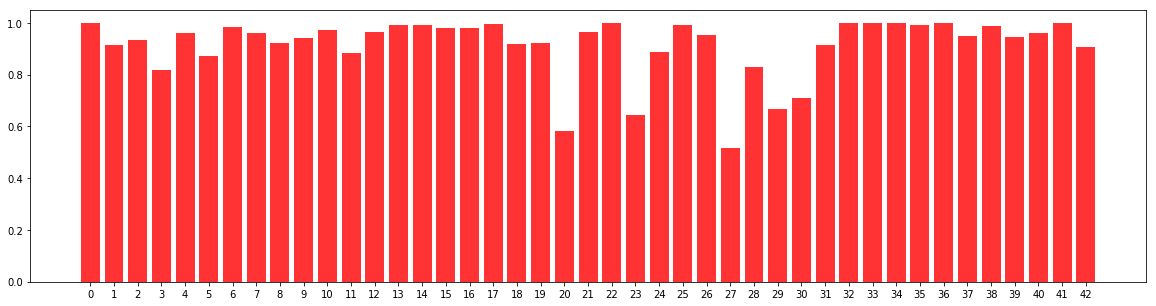

In [30]:
from sklearn.metrics import precision_recall_fscore_support
precision,recall, fbeta_score, _ = precision_recall_fscore_support(y_test, predictions, average=None)

fig, ax = plt.subplots(figsize=(20,5))
plt.xticks(range(n_classes), range(n_classes))
plot = plt.bar(range(n_classes), precision, color="red", alpha=0.8, label='precision')

#### Recall

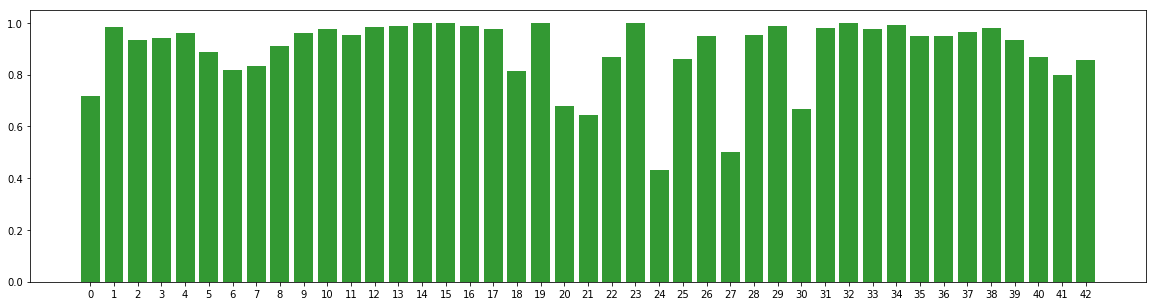

In [31]:
fig, ax = plt.subplots(figsize=(20,5))
plt.xticks(range(n_classes), range(n_classes))
plot = plt.bar(range(n_classes), recall, color="green", alpha=0.8, label='Recall')

#### Fβ score

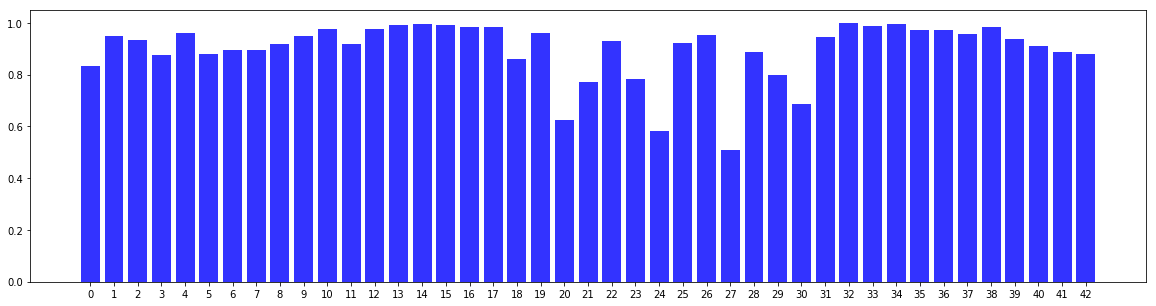

In [32]:
fig, ax = plt.subplots(figsize=(20,5))
plt.xticks(range(n_classes), range(n_classes))
plot = plt.bar(range(n_classes), fbeta_score, color="blue", alpha=0.8, label='Recall')

#### Confusion Matrix

In [33]:
# Adopted from: http://scikit-learn.org/stable/_downloads/plot_confusion_matrix.py
import itertools
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar(orientation='horizontal')
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization


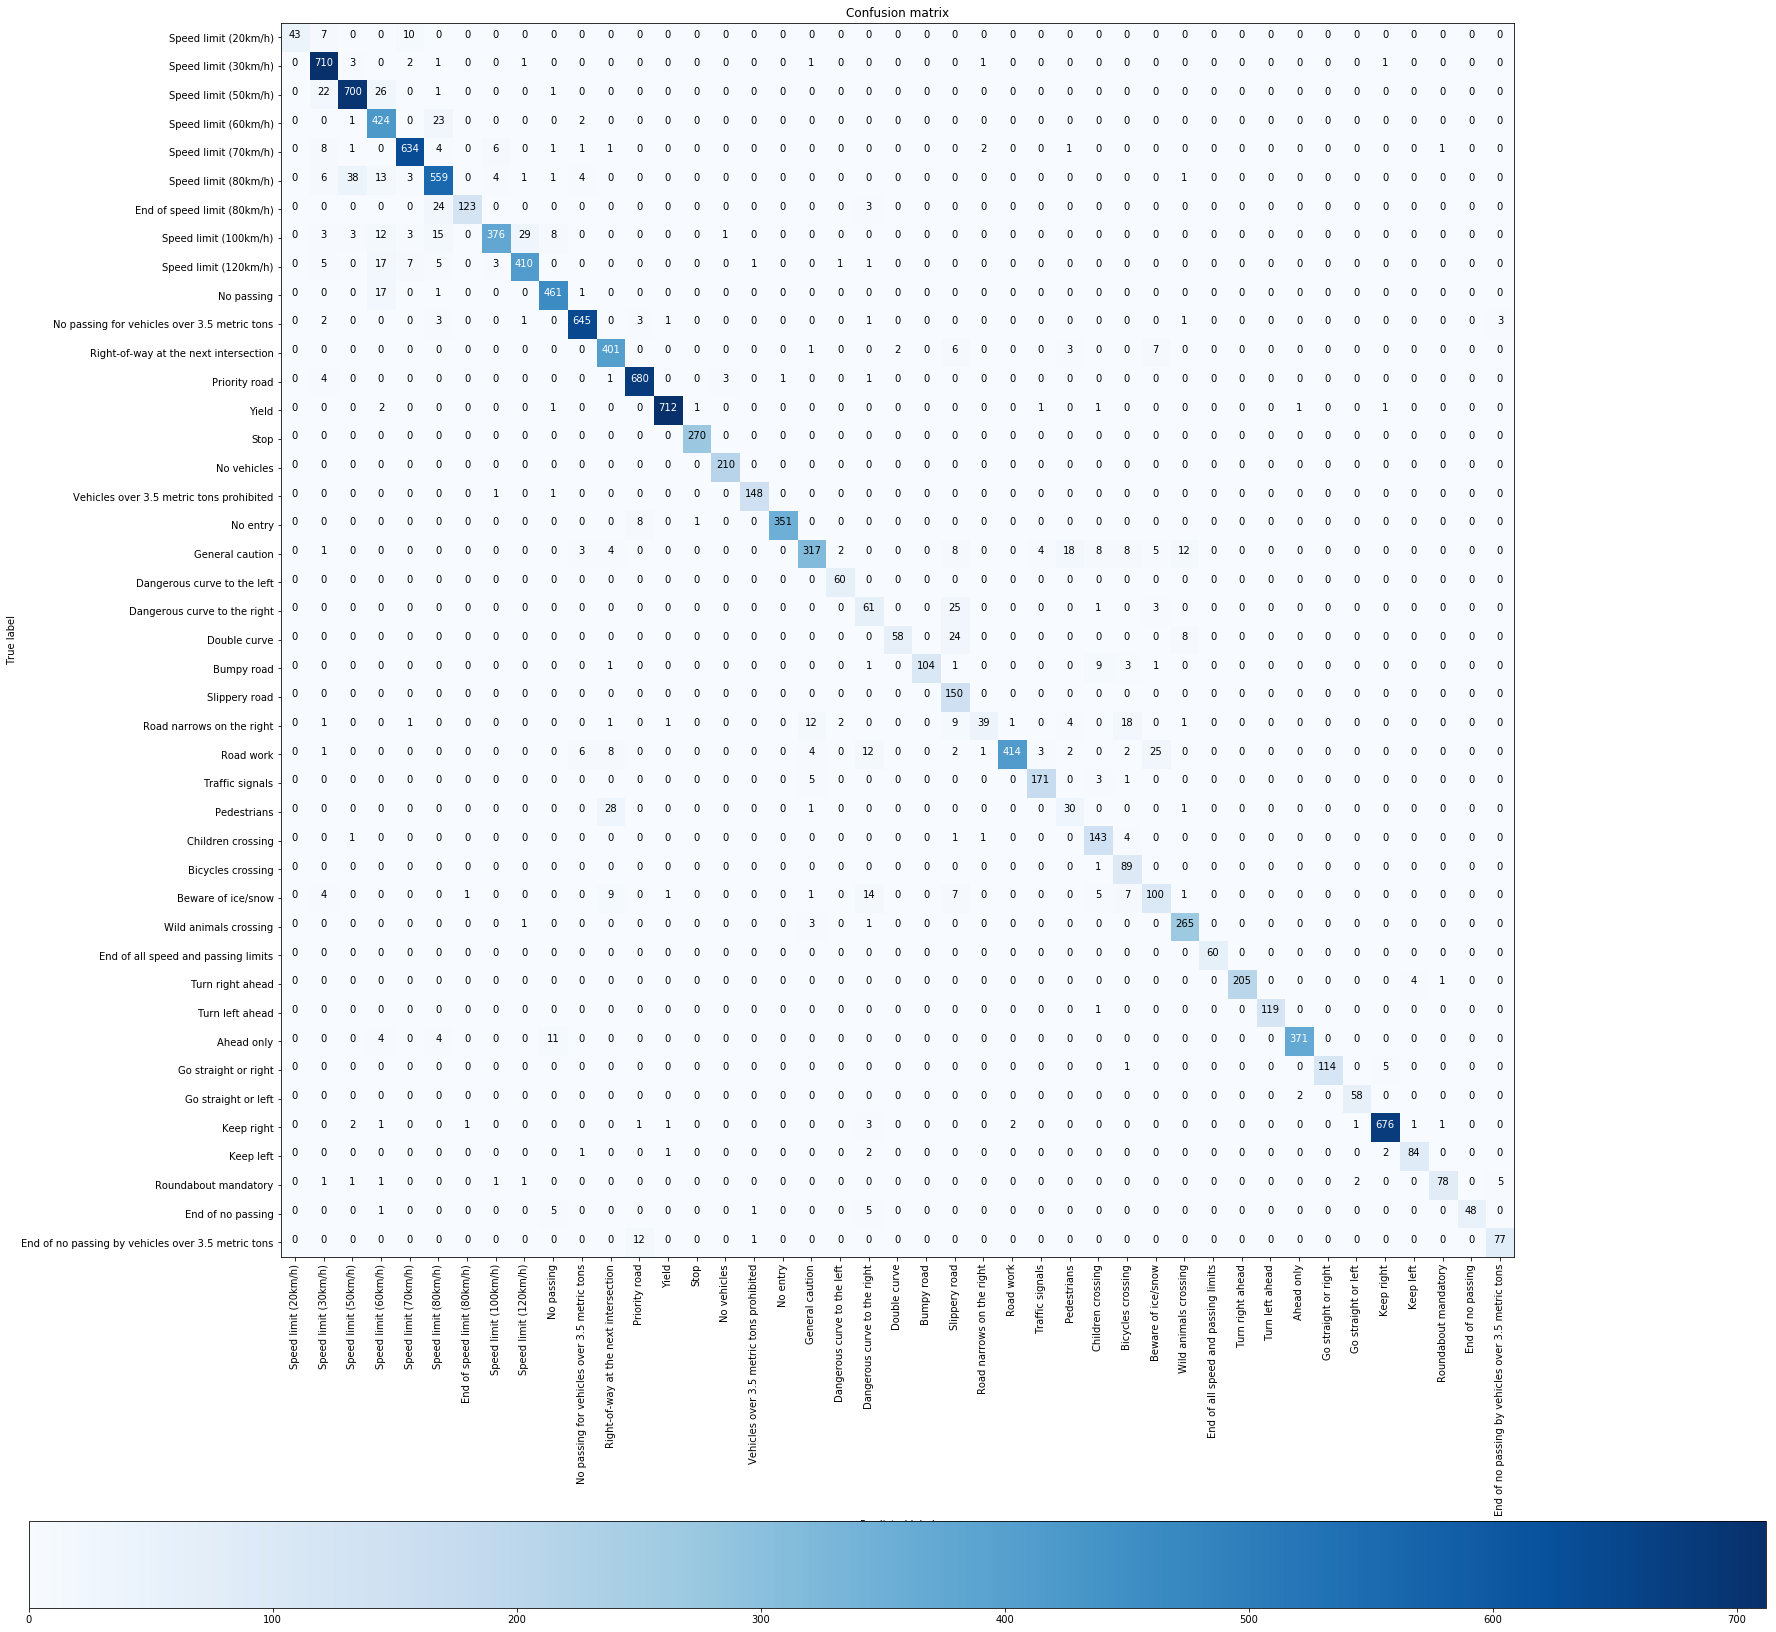

In [34]:
from sklearn.metrics import confusion_matrix
c_matrix = confusion_matrix(y_test, predictions)
plt.figure(figsize=(25,25))
plot_confusion_matrix(c_matrix, classes=sign_names.values())

Normalized confusion matrix


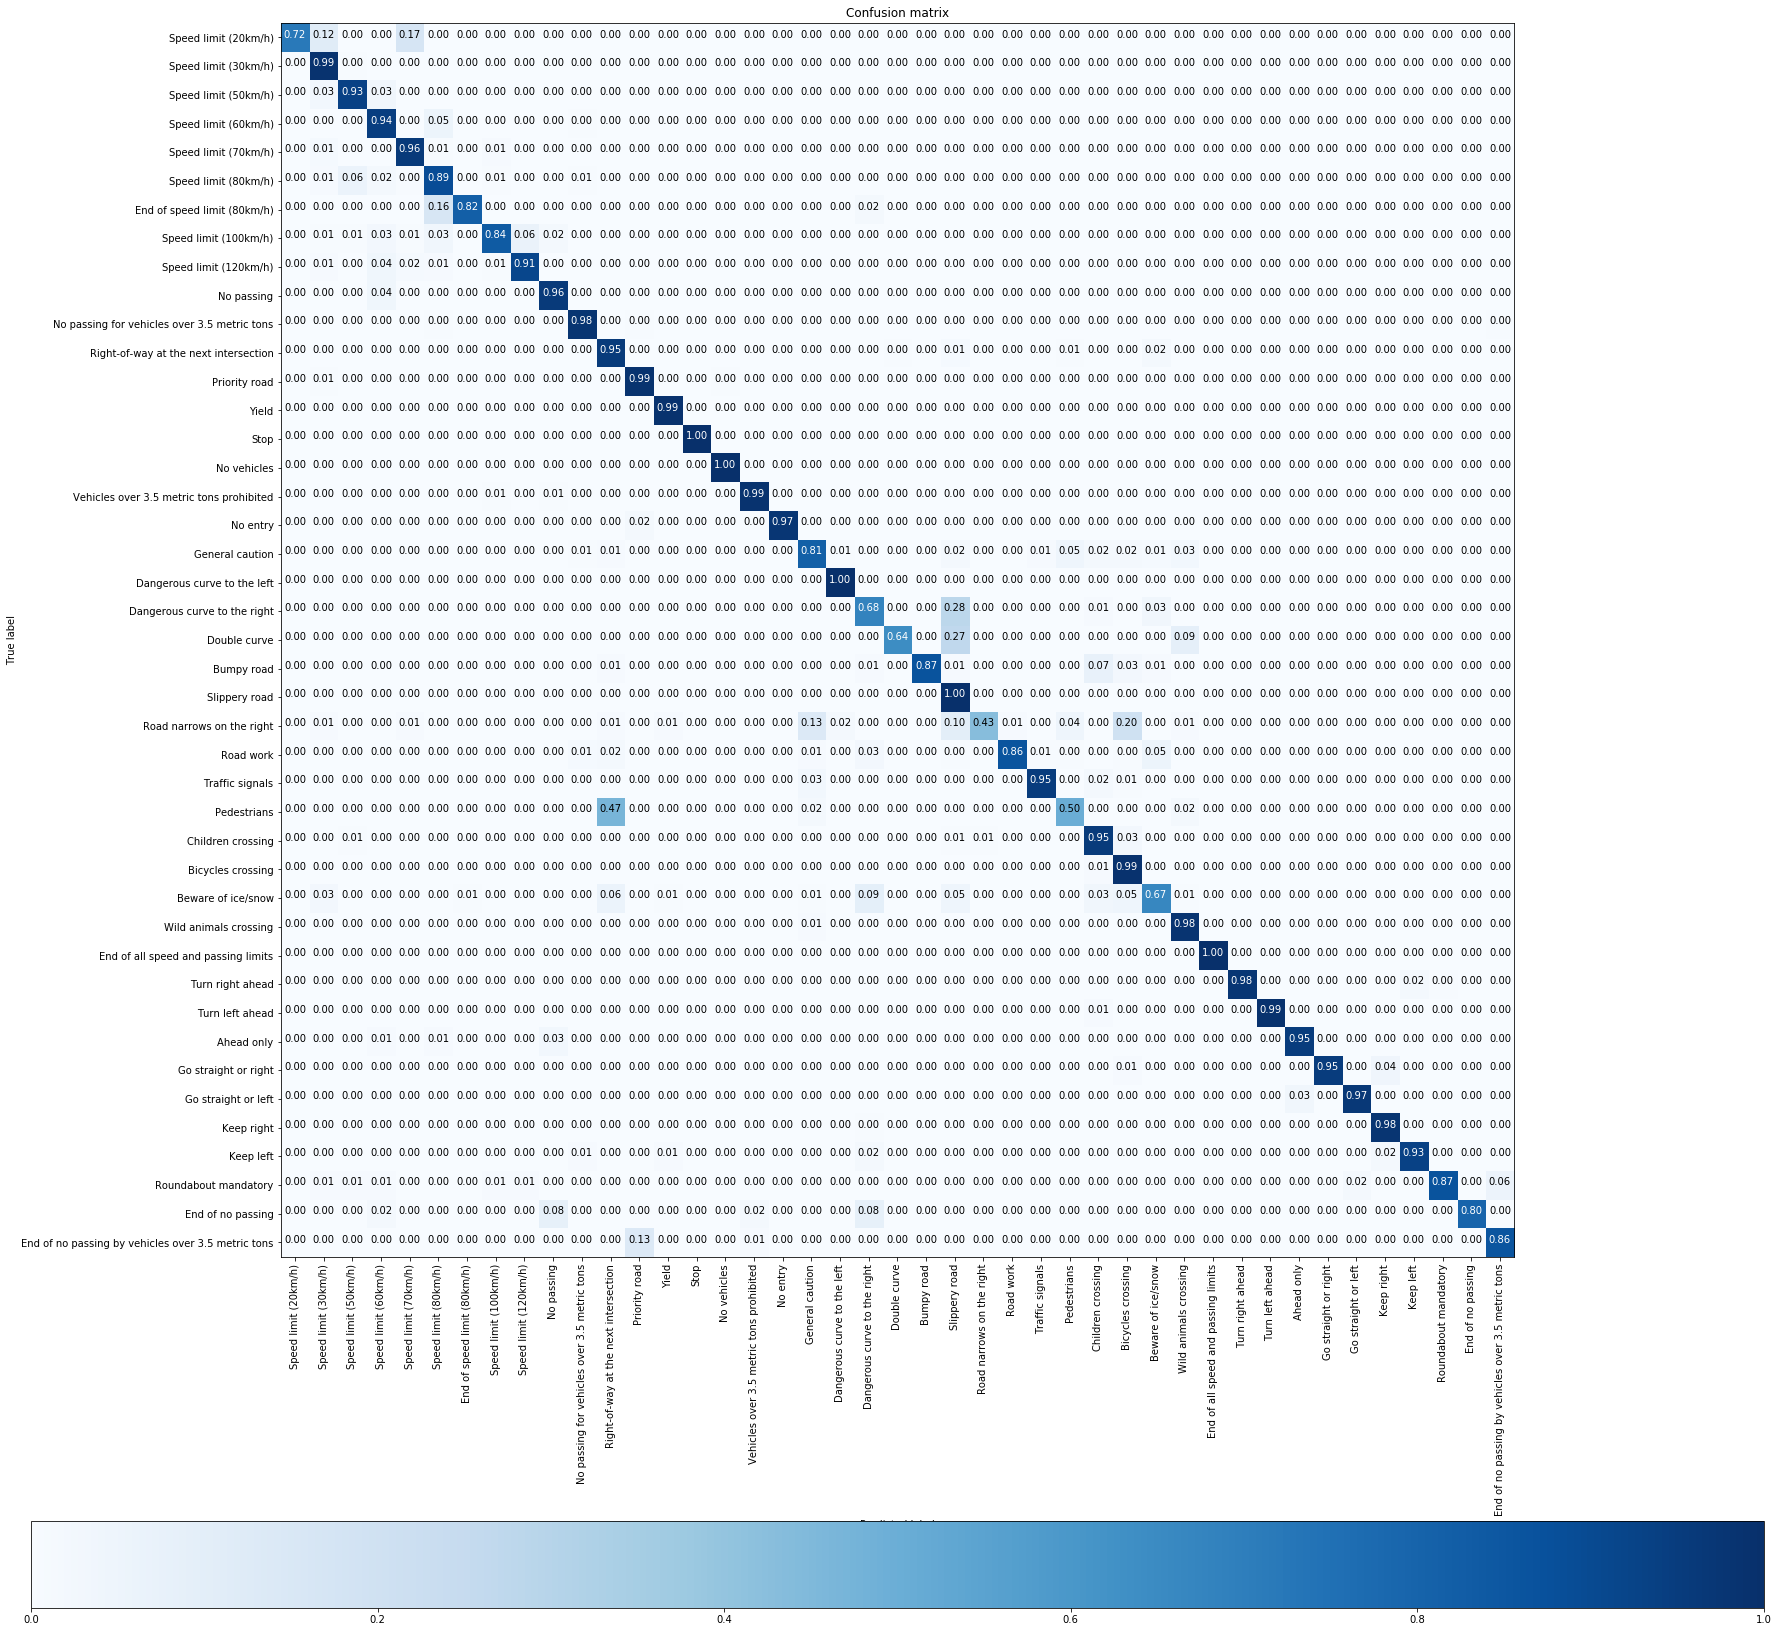

In [35]:
plt.figure(figsize=(25,25))
plot_confusion_matrix(c_matrix, classes=sign_names.values(), normalize=True)

---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

In [36]:
from PIL import Image
from scipy import misc
import numpy                                                                     
import glob

imageFolderPath = 'my_own_images/'
imagePath = glob.glob(imageFolderPath + '/*.png') 

X_myown = numpy.array( [numpy.array(misc.imread(img, mode='RGB')) for img in imagePath] )
Y_myown = numpy.array( [int(path.split("/")[1].split(".")[0]) for path in imagePath])


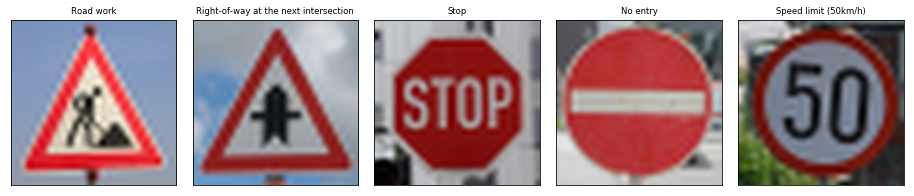

In [37]:
count = len(X_myown)
columns = count
rows = 1

fig, axes = plt.subplots(rows, columns, figsize=figsize,
                         subplot_kw={'xticks': [], 'yticks': []})

fig.subplots_adjust(hspace=0.3, wspace=0.10)

indices = range(count)

for ax, i in zip(axes.flat, indices):
    ax.imshow(X_myown[i], interpolation='lanczos')
    ax.set_title(sign_names[Y_myown[i]], fontsize=fontsize)
    
plt.show()

#### Pre-Processing

In [38]:
%%time
X_myown = preprocess(X_myown)

CPU times: user 568 ms, sys: 568 ms, total: 1.14 s
Wall time: 1.05 s


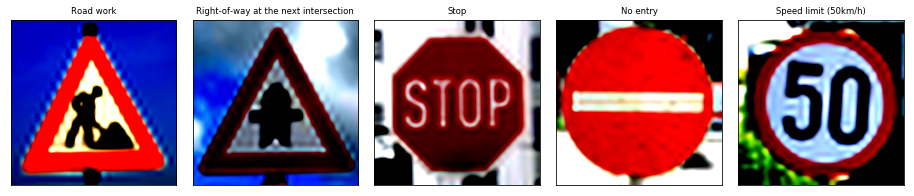

In [39]:
fig, axes = plt.subplots(rows, columns, figsize=figsize,
                         subplot_kw={'xticks': [], 'yticks': []})

fig.subplots_adjust(hspace=0.3, wspace=0.10)

indices = range(count)

for ax, i in zip(axes.flat, indices):
    ax.imshow(X_myown[i], interpolation='lanczos')
    ax.set_title(sign_names[Y_myown[i]], fontsize=fontsize)
    
plt.show()

### Predict the Sign Type for Each Image

In [40]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed.
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_myown, Y_myown)
    print("Test Accuracy = {:.3f}".format(test_accuracy))
    predictions = get_predictions(X_myown, Y_myown)

INFO:tensorflow:Restoring parameters from ./lenet
Test Accuracy = 0.800


### Analyze Performance

In [41]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tk.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

In [42]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    sf = sess.run(tf.nn.softmax(logits), feed_dict={x: X_myown, y: Y_myown, keep_prob: 1.0})
    topk = sess.run(tf.nn.top_k(tf.constant(sf), k=3))

INFO:tensorflow:Restoring parameters from ./lenet


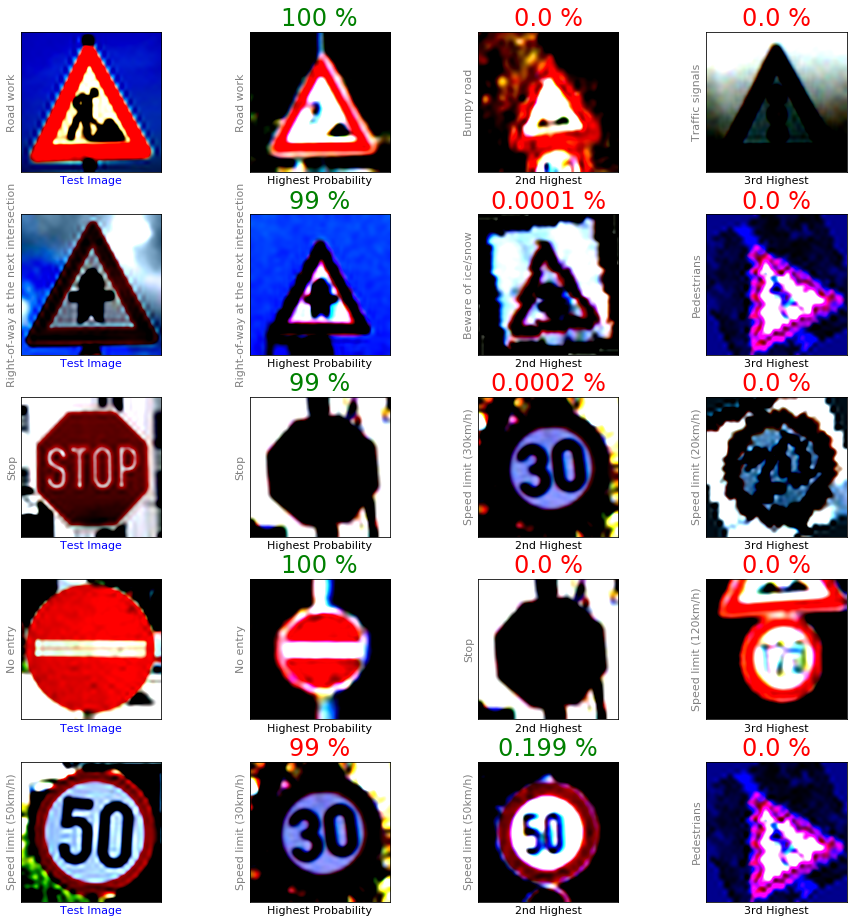

In [43]:
fig, axes = plt.subplots(5, 4, figsize=figsize,
                         subplot_kw={'xticks': [], 'yticks': []})

fig.subplots_adjust(hspace=0.3, wspace=0.10)
x_label = ["Highest Probability", "2nd Highest", "3rd Highest"]

for index in indices:
    axes[index][0].imshow(X_myown[index], interpolation='lanczos')
    axes[index][0].set_ylabel(sign_names[Y_myown[index]], fontsize=11, color="grey")
    axes[index][0].set_xlabel("Test Image", fontsize=11, color="blue")
    
    for num, name in enumerate(topk.indices[index]):
        ax = axes[index][num+1]
        ax.imshow(X_train[numpy.where(y_train==name)[0][0]], interpolation='lanczos')
        score = topk.values[index][num] * 100                   # scale to 100
        score = int(score) if score > 1 else round(score, 4)    # high title precesion for small numbers
        color = "green" if name == Y_myown[index] else "red"    # green color for correct prediction
        ax.set_title(str(score) + " %", fontsize=24, color=color)
        ax.set_ylabel(sign_names[name], fontsize=11, color="grey")
        ax.set_xlabel(x_label[num], fontsize=11)
    
plt.show()

### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [44]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")

INFO:tensorflow:Restoring parameters from ./lenet


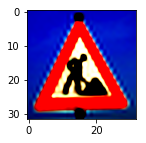

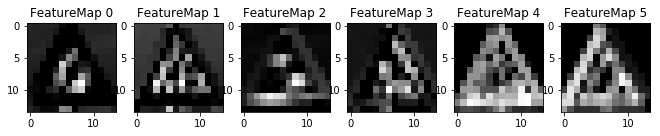

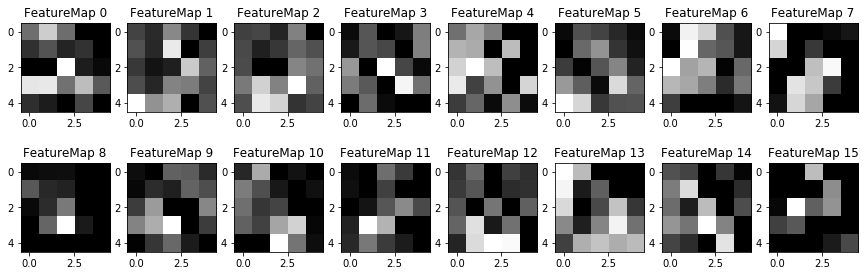

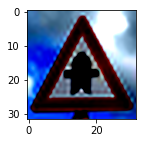

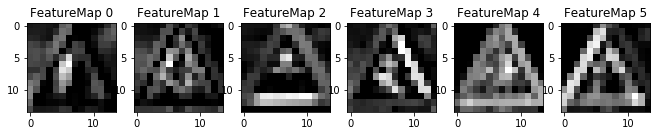

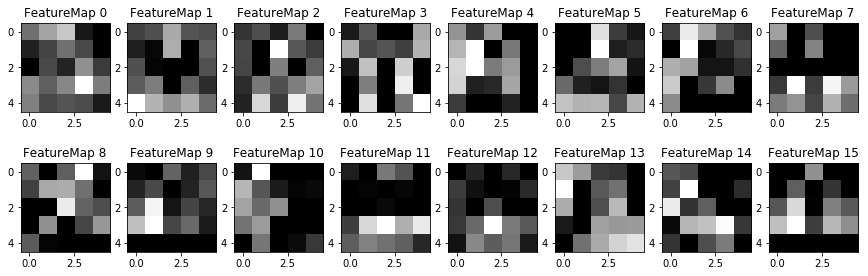

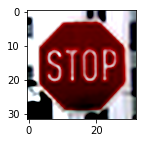

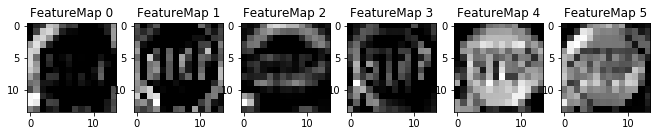

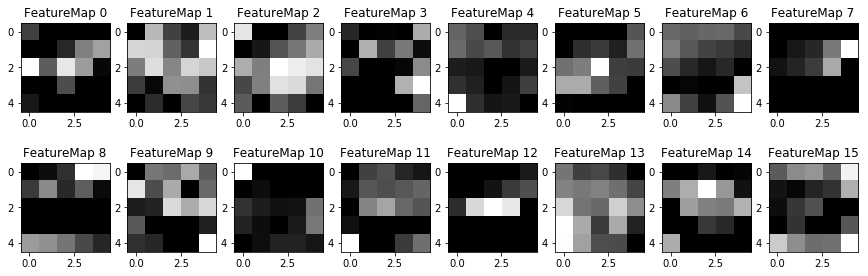

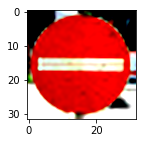

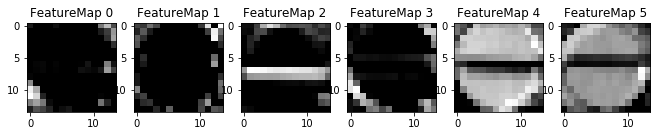

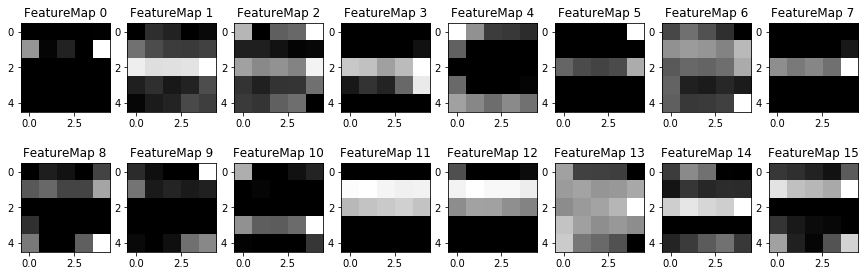

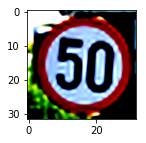

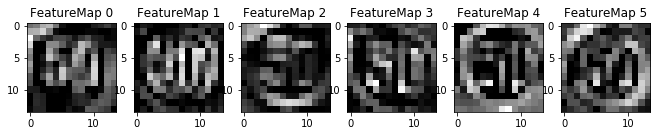

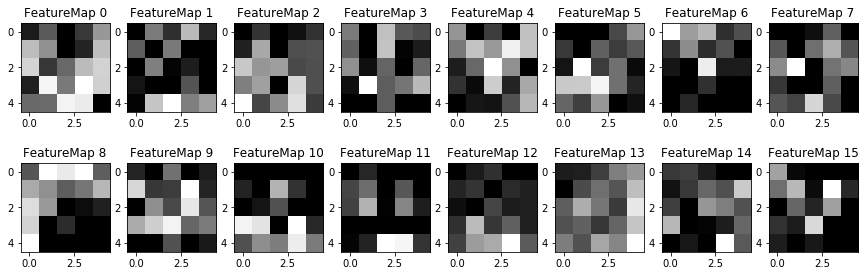

In [45]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    for i in indices:
        plt.figure(0, figsize=(2,2))
        plt.imshow(X_myown[i], interpolation='lanczos')
        test_accuracy = evaluate(X_myown[i:i+1], Y_myown[i:i+1])
        tf_activation = sess.graph.get_tensor_by_name('conv1:0')
        outputFeatureMap(X_myown[i:i+1], tf_activation, plt_num=1)
        tf_activation2 = sess.graph.get_tensor_by_name('conv2:0')
        outputFeatureMap(X_myown[i:i+1], tf_activation2, plt_num=2)
        plt.show()